In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
np.random.seed(69)
def generate_lob_data(n_samples=1000, n_levels=5, base_price=69):
    data = {}
    for level in range(1, n_levels + 1):
    #цены и объемы для каждого уровня (5) стакана
        data[f'bid_price_{level}'] = base_price - 0.1 * level + np.cumsum(np.random.normal(0, 0.05, n_samples))
        data[f'bid_volume_{level}'] = np.abs(np.random.normal(69, 7, n_samples))
        data[f'ask_price_{level}'] = base_price + 0.1 * level + np.cumsum(np.random.normal(0, 0.05, n_samples))
        data[f'ask_volume_{level}'] = np.abs(np.random.normal(69, 7, n_samples))
    
    df = pd.DataFrame(data)
    df['spread'] = df['ask_price_1'] - df['bid_price_1']
    
    #Order Imbalance для N уровней
    df['total_bid_volume'] = sum(df[f'bid_volume_{level}'] for level in range(1, n_levels + 1))
    df['total_ask_volume'] = sum(df[f'ask_volume_{level}'] for level in range(1, n_levels + 1))
    df['imbalance'] = (df['total_bid_volume'] - df['total_ask_volume']) / (df['total_bid_volume'] + df['total_ask_volume'])
    df['total_volume'] = df['total_bid_volume'] + df['total_ask_volume']
    # средняя цена лучших уровней
    df['mid_price'] = (df['bid_price_1'] + df['ask_price_1']) / 2
    
    return df

df = generate_lob_data(n_levels=5)

In [3]:
df.describe()

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,bid_price_5,bid_volume_5,ask_price_5,ask_volume_5,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,67.579778,69.032500,69.119216,68.899790,69.488200,69.113380,67.887020,69.045269,67.558030,68.822588,...,69.247724,68.611755,69.695617,68.756272,1.539438,344.571966,344.583477,-0.000036,689.155442,68.349497
std,0.725418,6.988465,0.596888,7.001481,0.444859,7.039280,0.845654,7.315992,0.547122,7.063026,...,0.605186,6.915646,0.424142,6.966237,0.667753,16.005865,15.706834,0.032903,22.231619,0.574265
min,66.543949,43.499817,67.749674,46.175232,68.642291,47.032130,66.311801,47.418537,66.263944,47.692421,...,68.130281,46.277759,68.644843,47.607907,-0.033597,292.838285,282.584671,-0.114622,611.604411,67.324638
25%,66.998708,64.519779,68.544143,64.116296,69.087565,64.490032,67.246695,64.240734,67.091652,64.009866,...,68.700684,63.796168,69.447729,64.326794,1.070253,333.882078,333.931904,-0.021942,675.678308,67.837515
50%,67.231025,68.873792,69.299408,69.130640,69.428110,68.961864,67.901396,68.825530,67.619738,68.703062,...,69.291322,68.730918,69.661429,68.569808,1.438083,344.074387,344.601547,0.000239,687.852775,68.218028
75%,68.389668,73.621165,69.603586,73.627731,69.854527,73.803514,68.642182,73.853628,67.900769,73.799312,...,69.752308,72.990704,70.060150,73.325812,1.900422,355.518348,355.291101,0.021713,703.951640,68.885515
max,69.073860,93.213862,70.255255,89.449069,70.450619,89.115670,69.284686,95.151159,68.926943,87.273321,...,70.414079,90.141962,70.526247,88.699766,3.408819,389.826469,399.710996,0.092106,755.080768,69.512929


In [4]:
from sklearn.preprocessing import StandardScaler

# Масштабирование данных
scaler = StandardScaler()
scaled = scaler.fit_transform(df)
features = ['bid_price_1', 'bid_volume_1', 'ask_price_1', 'ask_volume_1',
            'bid_price_2', 'bid_volume_2', 'ask_price_2', 'ask_volume_2',
            'bid_price_3', 'bid_volume_3', 'ask_price_3', 'ask_volume_3',
            'bid_price_4', 'bid_volume_4', 'ask_price_4', 'ask_volume_4',
            'bid_price_5', 'bid_volume_5', 'ask_price_5', 'ask_volume_5',
            'spread', 'total_bid_volume', 'total_ask_volume', 
            'imbalance', 'total_volume', 'mid_price']
scaled_df = pd.DataFrame(scaled, columns=features)

X = scaled_df[features].values if hasattr(scaled_df, 'values') else scaled_df[:, :26]
scaled_df.describe()

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,bid_price_5,bid_volume_5,ask_price_5,ask_volume_5,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,...,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.597300e-14,-1.005418e-15,-1.762146e-15,-1.820766e-15,-1.341505e-14,3.712586e-16,6.565415e-15,1.021405e-15,-2.586376e-14,1.776357e-15,...,8.355983e-15,-2.984279e-16,-6.195933e-15,2.167155e-16,1.918465e-16,-1.033840e-15,1.357137e-15,-1.065814e-17,2.629008e-16,-1.085709e-14
std,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,...,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00,1.000500e+00
min,-1.428620e+00,-3.655375e+00,-2.295619e+00,-3.247303e+00,-1.902472e+00,-3.138432e+00,-1.863654e+00,-2.957569e+00,-2.366446e+00,-2.993156e+00,...,-1.847370e+00,-3.231104e+00,-2.478650e+00,-3.037357e+00,-2.356893e+00,-3.233788e+00,-3.949226e+00,-3.484274e+00,-3.490067e+00,-1.785539e+00
25%,-8.014149e-01,-6.460615e-01,-9.639341e-01,-6.835535e-01,-9.010391e-01,-6.571214e-01,-7.575743e-01,-6.570454e-01,-8.528478e-01,-6.817376e-01,...,-9.043730e-01,-6.966805e-01,-5.847381e-01,-6.361676e-01,-7.029832e-01,-6.682074e-01,-6.784883e-01,-6.661050e-01,-6.065181e-01,-8.919893e-01
50%,-4.810018e-01,-2.272136e-02,3.020377e-01,3.298811e-02,-1.351448e-01,-2.153508e-02,1.700833e-02,-3.005041e-02,1.128428e-01,-1.693116e-02,...,7.207683e-02,1.723961e-02,-8.064427e-02,-2.678022e-02,-1.518613e-01,-3.110281e-02,1.151042e-03,8.363395e-03,-5.862458e-02,-2.290492e-01
75%,1.117003e+00,6.569341e-01,8.118986e-01,6.756151e-01,8.238795e-01,6.666138e-01,8.934381e-01,6.575685e-01,6.267544e-01,7.049690e-01,...,8.341837e-01,6.335113e-01,8.598892e-01,6.562835e-01,5.408659e-01,6.842404e-01,6.820587e-01,6.613422e-01,6.658805e-01,9.338664e-01
max,2.060645e+00,3.461914e+00,1.904222e+00,2.936459e+00,2.164505e+00,2.842947e+00,1.653589e+00,3.570118e+00,2.503279e+00,2.613606e+00,...,1.928232e+00,3.114818e+00,1.959357e+00,2.864311e+00,2.800910e+00,2.828785e+00,3.511535e+00,2.801810e+00,2.966870e+00,2.026965e+00


In [5]:
forest = IsolationForest(
    n_estimators=300,
    max_samples='auto',
    contamination='auto',
    max_features=1.0,
    bootstrap=False,
    random_state=69,
    verbose=0,
    warm_start=False
)

forest.fit(X)
# Предсказание аномалий (-1 для аномалий, 1 для нормальных точек)
predictions = forest.predict(X)
#scores (чем меньше, тем более аномальная точка)
scores = forest.decision_function(X)

scaled_df['anomaly_score'] = scores
scaled_df['is_anomaly'] = predictions
scaled_df

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,ask_price_5,ask_volume_5,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price,anomaly_score,is_anomaly
0,1.883990,1.379749,0.122580,1.280754,-1.537797,-0.935360,1.575961,0.935505,2.085630,-0.046955,...,-0.324855,0.454818,-1.937115,0.170479,1.679104,-0.999908,1.309039,1.253644,-0.014540,-1
1,1.842370,-1.177661,0.183063,-0.912566,-1.327896,0.139657,1.471988,0.249140,2.217062,0.000410,...,-0.058632,0.898215,-1.837836,-0.053721,-0.522260,0.328742,-0.407658,1.258789,0.017460,1
2,1.922522,-0.244576,0.151344,0.074531,-1.289217,-1.998091,1.457794,0.149557,2.239843,-0.206235,...,-0.050478,0.407522,-1.953262,-0.830914,-0.170812,-0.478728,-0.718904,1.292930,0.016799,1
3,1.881049,-0.081084,0.075228,1.958578,-1.157715,-0.607396,1.412859,0.141466,2.124893,-0.739793,...,0.056909,-0.204988,-1.976247,-0.927482,1.172247,-1.458534,0.160453,1.227178,-0.000757,-1
4,1.770886,-1.183436,-0.031013,1.401398,-0.974583,0.746914,1.406762,-0.752080,2.168818,-0.242374,...,0.236738,0.800351,-1.951537,0.052479,0.538526,-0.330913,0.418256,1.102385,0.011607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.858059,0.499528,-1.703887,-0.832042,1.375931,-0.589175,0.623427,-0.317100,-0.954665,0.496960,...,0.057944,-2.320716,-0.590904,-0.190216,-1.783893,1.153939,-1.397284,-1.427461,0.033158,1
996,-0.958744,0.110268,-1.658989,0.894896,1.138780,-2.346937,0.610960,-0.046354,-1.132926,-0.379275,...,0.040487,-0.254506,-0.441391,-0.862764,0.390304,-0.888673,-0.345402,-1.467721,0.056450,1
997,-0.918475,-0.017574,-1.715257,0.099665,1.175739,-2.133980,0.611271,1.680274,-1.286709,-0.000687,...,0.166720,-1.235598,-0.535434,-0.721258,0.245301,-0.686103,-0.345969,-1.471530,0.034147,1
998,-0.855855,0.285850,-1.653489,-0.429006,1.016647,-0.419167,0.626090,0.232828,-1.345500,0.390258,...,0.078446,1.815825,-0.548249,0.104876,0.470063,-0.247712,0.407610,-1.399878,0.055673,1


In [6]:
#топ-10 аномалий
anomalies = scaled_df[scaled_df['is_anomaly'] == -1].sort_values('anomaly_score').head(10)

# Вывод статистики
print(anomalies.describe())

# Или только по исходным признакам
print(anomalies[features].describe())

       bid_price_1  bid_volume_1  ask_price_1  ask_volume_1  bid_price_2  \
count    10.000000     10.000000    10.000000     10.000000    10.000000   
mean      0.788966     -0.505671    -0.090625     -0.114756    -0.400969   
std       1.257571      1.309455     0.864558      1.333986     0.992016   
min      -1.104240     -2.054618    -2.256884     -1.802603    -1.204813   
25%      -0.406028     -1.276040    -0.154336     -1.280232    -0.967750   
50%       1.141453     -0.756624    -0.128166     -0.003269    -0.929124   
75%       1.915938     -0.278125     0.337975      0.894041    -0.047912   
max       2.045147      2.392686     0.961862      1.698384     1.685495   

       bid_volume_2  ask_price_2  ask_volume_2  bid_price_3  bid_volume_3  \
count     10.000000    10.000000     10.000000    10.000000     10.000000   
mean       0.029549     0.785680     -0.036404     1.326861     -0.763648   
std        1.574447     1.114348      1.916490     1.183527      1.567620   
min    

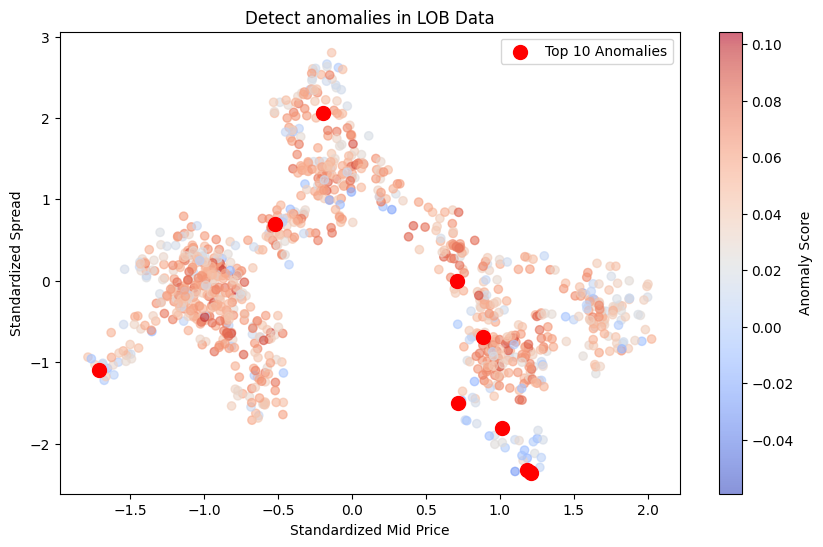

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(scaled_df['mid_price'], scaled_df['spread'], 
            c=scaled_df['anomaly_score'], cmap='coolwarm', alpha=0.6)
plt.colorbar(label='Anomaly Score')
plt.scatter(anomalies['mid_price'], anomalies['spread'], 
            color='red', s=100, label='Top 10 Anomalies')
plt.xlabel('Standardized Mid Price')
plt.ylabel('Standardized Spread')
plt.title('Detect anomalies in LOB Data')
plt.legend()
plt.show()

In [8]:
scaled_df

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,ask_price_5,ask_volume_5,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price,anomaly_score,is_anomaly
0,1.883990,1.379749,0.122580,1.280754,-1.537797,-0.935360,1.575961,0.935505,2.085630,-0.046955,...,-0.324855,0.454818,-1.937115,0.170479,1.679104,-0.999908,1.309039,1.253644,-0.014540,-1
1,1.842370,-1.177661,0.183063,-0.912566,-1.327896,0.139657,1.471988,0.249140,2.217062,0.000410,...,-0.058632,0.898215,-1.837836,-0.053721,-0.522260,0.328742,-0.407658,1.258789,0.017460,1
2,1.922522,-0.244576,0.151344,0.074531,-1.289217,-1.998091,1.457794,0.149557,2.239843,-0.206235,...,-0.050478,0.407522,-1.953262,-0.830914,-0.170812,-0.478728,-0.718904,1.292930,0.016799,1
3,1.881049,-0.081084,0.075228,1.958578,-1.157715,-0.607396,1.412859,0.141466,2.124893,-0.739793,...,0.056909,-0.204988,-1.976247,-0.927482,1.172247,-1.458534,0.160453,1.227178,-0.000757,-1
4,1.770886,-1.183436,-0.031013,1.401398,-0.974583,0.746914,1.406762,-0.752080,2.168818,-0.242374,...,0.236738,0.800351,-1.951537,0.052479,0.538526,-0.330913,0.418256,1.102385,0.011607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.858059,0.499528,-1.703887,-0.832042,1.375931,-0.589175,0.623427,-0.317100,-0.954665,0.496960,...,0.057944,-2.320716,-0.590904,-0.190216,-1.783893,1.153939,-1.397284,-1.427461,0.033158,1
996,-0.958744,0.110268,-1.658989,0.894896,1.138780,-2.346937,0.610960,-0.046354,-1.132926,-0.379275,...,0.040487,-0.254506,-0.441391,-0.862764,0.390304,-0.888673,-0.345402,-1.467721,0.056450,1
997,-0.918475,-0.017574,-1.715257,0.099665,1.175739,-2.133980,0.611271,1.680274,-1.286709,-0.000687,...,0.166720,-1.235598,-0.535434,-0.721258,0.245301,-0.686103,-0.345969,-1.471530,0.034147,1
998,-0.855855,0.285850,-1.653489,-0.429006,1.016647,-0.419167,0.626090,0.232828,-1.345500,0.390258,...,0.078446,1.815825,-0.548249,0.104876,0.470063,-0.247712,0.407610,-1.399878,0.055673,1


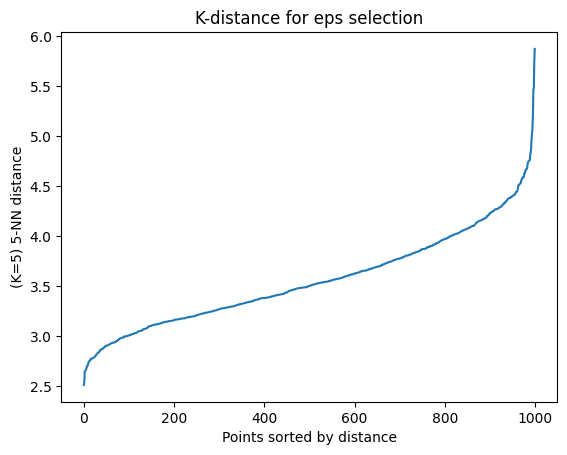

In [9]:
#dbscan Density-Based Spatial Clustering of Applications with Noise
from sklearn.neighbors import NearestNeighbors

# elbow для подбора eps
nn = NearestNeighbors(n_neighbors=5).fit(scaled)
distances, indices = nn.kneighbors(scaled)
distances = np.sort(distances[:, -1], axis=0)

plt.plot(distances)
plt.xlabel('Points sorted by distance')
plt.ylabel('(K=5) 5-NN distance')
plt.title('K-distance for eps selection')
plt.show()
#eps = 3.0  

In [10]:
dbscan = DBSCAN(
    eps=3,          #радиус окрестности
    min_samples=10,     #минимальное число точек в окрестности
    metric='euclidean', #метрика distance
    algorithm='auto',  #алгоритм поиска соседей ('auto', 'ball_tree', 'kd_tree', 'brute')
    p=None          #параметр для метрики Минковского (None=евклидова)
)

clusters = dbscan.fit_predict(X)

scaled_df['cluster'] = clusters
scaled_df['dbscan_is_anomaly'] = np.where(clusters == -1, 1, 0)  # -1= шум/аномалия
scaled_df

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price,anomaly_score,is_anomaly,cluster,dbscan_is_anomaly
0,1.883990,1.379749,0.122580,1.280754,-1.537797,-0.935360,1.575961,0.935505,2.085630,-0.046955,...,-1.937115,0.170479,1.679104,-0.999908,1.309039,1.253644,-0.014540,-1,-1,1
1,1.842370,-1.177661,0.183063,-0.912566,-1.327896,0.139657,1.471988,0.249140,2.217062,0.000410,...,-1.837836,-0.053721,-0.522260,0.328742,-0.407658,1.258789,0.017460,1,-1,1
2,1.922522,-0.244576,0.151344,0.074531,-1.289217,-1.998091,1.457794,0.149557,2.239843,-0.206235,...,-1.953262,-0.830914,-0.170812,-0.478728,-0.718904,1.292930,0.016799,1,-1,1
3,1.881049,-0.081084,0.075228,1.958578,-1.157715,-0.607396,1.412859,0.141466,2.124893,-0.739793,...,-1.976247,-0.927482,1.172247,-1.458534,0.160453,1.227178,-0.000757,-1,-1,1
4,1.770886,-1.183436,-0.031013,1.401398,-0.974583,0.746914,1.406762,-0.752080,2.168818,-0.242374,...,-1.951537,0.052479,0.538526,-0.330913,0.418256,1.102385,0.011607,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.858059,0.499528,-1.703887,-0.832042,1.375931,-0.589175,0.623427,-0.317100,-0.954665,0.496960,...,-0.590904,-0.190216,-1.783893,1.153939,-1.397284,-1.427461,0.033158,1,-1,1
996,-0.958744,0.110268,-1.658989,0.894896,1.138780,-2.346937,0.610960,-0.046354,-1.132926,-0.379275,...,-0.441391,-0.862764,0.390304,-0.888673,-0.345402,-1.467721,0.056450,1,-1,1
997,-0.918475,-0.017574,-1.715257,0.099665,1.175739,-2.133980,0.611271,1.680274,-1.286709,-0.000687,...,-0.535434,-0.721258,0.245301,-0.686103,-0.345969,-1.471530,0.034147,1,-1,1
998,-0.855855,0.285850,-1.653489,-0.429006,1.016647,-0.419167,0.626090,0.232828,-1.345500,0.390258,...,-0.548249,0.104876,0.470063,-0.247712,0.407610,-1.399878,0.055673,1,-1,1


Explained variance ratio: [0.21572051 0.11672539]
Total explained variance: 33.24%

Top features per component:

PC1:
mid_price      0.396261
ask_price_3    0.354945
bid_price_1    0.351823
bid_price_5    0.348386
ask_price_1    0.334900
Name: PC1, dtype: float64

PC2:
imbalance           0.507466
total_bid_volume    0.496950
bid_volume_1        0.243641
bid_volume_4        0.238221
bid_volume_2        0.228018
Name: PC2, dtype: float64


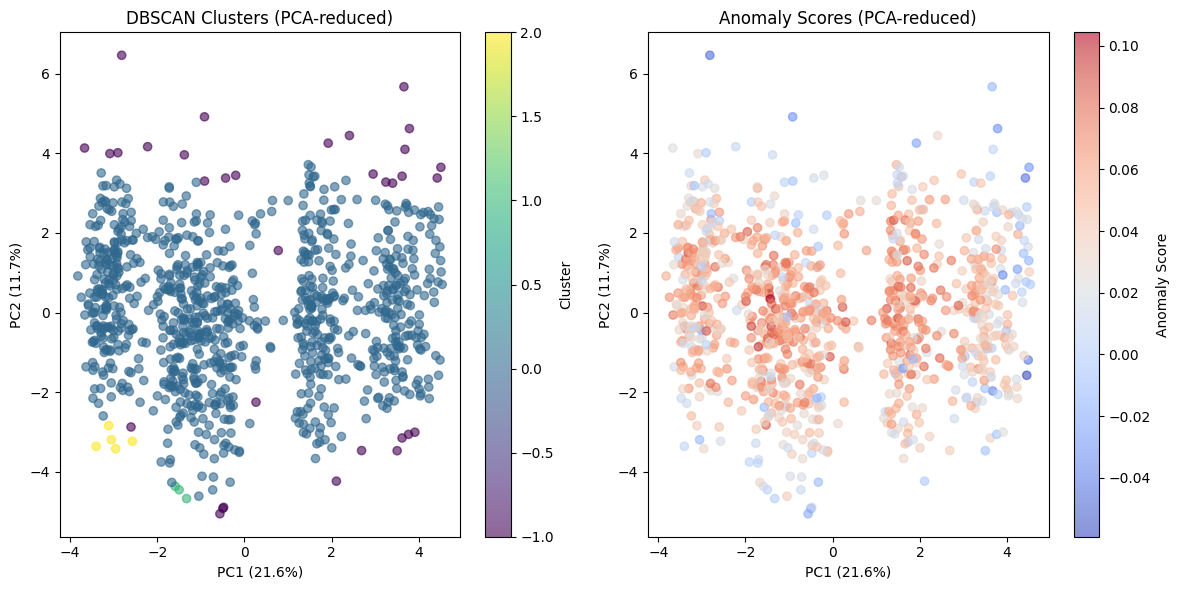

In [11]:
#pca для dbscan
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
X_pc= scaled_df.values if hasattr(scaled_df, 'values') else scaled_df

pca = PCA(n_components=2)  
X_pca = pca.fit_transform(X_pc)

#анализ объясненной дисперсии
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2%}")

#визуализация нагрузки компонент
loadings = pd.DataFrame(pca.components_, columns=scaled_df.columns, index=['PC1', 'PC2'])

#топ-5 признаков для каждой компоненты
print("\nTop features per component:")
for i, pc in enumerate(loadings.index):
    print(f"\n{pc}:")
    print(loadings.loc[pc].abs().sort_values(ascending=False).head(5))

#DBSCAN на PCA-признаках
dbscanpca = DBSCAN(eps=0.5, min_samples=5, metric= 'euclidean')
labels = dbscanpca.fit_predict(X_pca)

##визуализация
plt.figure(figsize=(12, 6))

#график кластеров
plt.subplot(1, 2, 1)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
plt.title("DBSCAN Clusters (PCA-reduced)")

#график аномалий (Isolation Forest scores)
if 'anomaly_score' in scaled_df.columns:
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=scaled_df['anomaly_score'], 
                        cmap='coolwarm', alpha=0.6)
    plt.colorbar(scatter, label='Anomaly Score')
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    plt.title("Anomaly Scores (PCA-reduced)")

plt.tight_layout()
plt.show()


In [12]:
scaled_df

,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price,anomaly_score,is_anomaly,cluster,dbscan_is_anomaly
0,1.883990,1.379749,0.122580,1.280754,-1.537797,-0.935360,1.575961,0.935505,2.085630,-0.046955,...,-1.937115,0.170479,1.679104,-0.999908,1.309039,1.253644,-0.014540,-1,-1,1
1,1.842370,-1.177661,0.183063,-0.912566,-1.327896,0.139657,1.471988,0.249140,2.217062,0.000410,...,-1.837836,-0.053721,-0.522260,0.328742,-0.407658,1.258789,0.017460,1,-1,1
2,1.922522,-0.244576,0.151344,0.074531,-1.289217,-1.998091,1.457794,0.149557,2.239843,-0.206235,...,-1.953262,-0.830914,-0.170812,-0.478728,-0.718904,1.292930,0.016799,1,-1,1
3,1.881049,-0.081084,0.075228,1.958578,-1.157715,-0.607396,1.412859,0.141466,2.124893,-0.739793,...,-1.976247,-0.927482,1.172247,-1.458534,0.160453,1.227178,-0.000757,-1,-1,1
4,1.770886,-1.183436,-0.031013,1.401398,-0.974583,0.746914,1.406762,-0.752080,2.168818,-0.242374,...,-1.951537,0.052479,0.538526,-0.330913,0.418256,1.102385,0.011607,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.858059,0.499528,-1.703887,-0.832042,1.375931,-0.589175,0.623427,-0.317100,-0.954665,0.496960,...,-0.590904,-0.190216,-1.783893,1.153939,-1.397284,-1.427461,0.033158,1,-1,1
996,-0.958744,0.110268,-1.658989,0.894896,1.138780,-2.346937,0.610960,-0.046354,-1.132926,-0.379275,...,-0.441391,-0.862764,0.390304,-0.888673,-0.345402,-1.467721,0.056450,1,-1,1
997,-0.918475,-0.017574,-1.715257,0.099665,1.175739,-2.133980,0.611271,1.680274,-1.286709,-0.000687,...,-0.535434,-0.721258,0.245301,-0.686103,-0.345969,-1.471530,0.034147,1,-1,1
998,-0.855855,0.285850,-1.653489,-0.429006,1.016647,-0.419167,0.626090,0.232828,-1.345500,0.390258,...,-0.548249,0.104876,0.470063,-0.247712,0.407610,-1.399878,0.055673,1,-1,1


,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,bid_price_2,bid_volume_2,ask_price_2,ask_volume_2,bid_price_3,bid_volume_3,...,ask_volume_5,spread,total_bid_volume,total_ask_volume,imbalance,total_volume,mid_price,anomaly_score,is_anomaly,cluster
0,1.883990,1.379749,0.122580,1.280754,-1.537797,-0.935360,1.575961,0.935505,2.085630,-0.046955,...,0.454818,-1.937115,0.170479,1.679104,-0.999908,1.309039,1.253644,-0.014540,1,-1
1,1.842370,-1.177661,0.183063,-0.912566,-1.327896,0.139657,1.471988,0.249140,2.217062,0.000410,...,0.898215,-1.837836,-0.053721,-0.522260,0.328742,-0.407658,1.258789,0.017460,1,-1
2,1.922522,-0.244576,0.151344,0.074531,-1.289217,-1.998091,1.457794,0.149557,2.239843,-0.206235,...,0.407522,-1.953262,-0.830914,-0.170812,-0.478728,-0.718904,1.292930,0.016799,1,-1
3,1.881049,-0.081084,0.075228,1.958578,-1.157715,-0.607396,1.412859,0.141466,2.124893,-0.739793,...,-0.204988,-1.976247,-0.927482,1.172247,-1.458534,0.160453,1.227178,-0.000757,1,-1
4,1.770886,-1.183436,-0.031013,1.401398,-0.974583,0.746914,1.406762,-0.752080,2.168818,-0.242374,...,0.800351,-1.951537,0.052479,0.538526,-0.330913,0.418256,1.102385,0.011607,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.858059,0.499528,-1.703887,-0.832042,1.375931,-0.589175,0.623427,-0.317100,-0.954665,0.496960,...,-2.320716,-0.590904,-0.190216,-1.783893,1.153939,-1.397284,-1.427461,0.033158,1,-1
996,-0.958744,0.110268,-1.658989,0.894896,1.138780,-2.346937,0.610960,-0.046354,-1.132926,-0.379275,...,-0.254506,-0.441391,-0.862764,0.390304,-0.888673,-0.345402,-1.467721,0.056450,1,-1
997,-0.918475,-0.017574,-1.715257,0.099665,1.175739,-2.133980,0.611271,1.680274,-1.286709,-0.000687,...,-1.235598,-0.535434,-0.721258,0.245301,-0.686103,-0.345969,-1.471530,0.034147,1,-1
998,-0.855855,0.285850,-1.653489,-0.429006,1.016647,-0.419167,0.626090,0.232828,-1.345500,0.390258,...,1.815825,-0.548249,0.104876,0.470063,-0.247712,0.407610,-1.399878,0.055673,1,-1


In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
# сравнение (unsupervised поэтому не roc auc)
# DBSCAN
dbscan_labels = dbscan.fit_predict(X)
if len(np.unique(dbscan_labels)) > 1:
    print("DBSCAN Metrics:")
    print(f"Silhouette: {silhouette_score(X, dbscan_labels):.4f}")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(X, dbscan_labels):.4f}")
    print(f"Davies-Bouldin: {davies_bouldin_score(X, dbscan_labels):.4f}")
else:
    print("DBSCAN found only 1 cluster - metrics unavailable")

# Isolation Forest
forest_scores = forest.decision_function(X)
print("\nIsolation Forest Score Stats:")
print(f"Mean: {np.mean(forest_scores):.4f}")
print(f"Std: {np.std(forest_scores):.4f}")
print(f"Min: {np.min(forest_scores):.4f}")
print(f"5% percentile: {np.percentile(forest_scores, 5):.4f}")

DBSCAN Metrics:
Silhouette: -0.2209
Calinski-Harabasz: 9.5692
Davies-Bouldin: 2.3986

Isolation Forest Score Stats:
Mean: 0.0445
Std: 0.0244
Min: -0.0591
5% percentile: 0.0000


In [ ]:
#Для мониторинга этих искуственных LOB данных Isolation Forest показал себя значительно лучше